# FashionMNIST VAE

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import torch
import torchvision
import torchvision.transforms as tvt
import pyro
from pyro.infer import SVI, Trace_ELBO #, TraceGraph_ELBO
from pyro.optim import Adam, Adamax, Adadelta, SGD
from torchvision import utils
from helper_functions import *



### Define the simulation parameters

In [2]:
params = { 
    'CHANNELS' : 1,
    'WIDTH' : 28,
    'HEIGHT':28, 
    'DIM_Z':2,
    'SCALE':2,
    'use_cuda' : torch.cuda.is_available()
    }
print(params)

{'HEIGHT': 28, 'use_cuda': True, 'CHANNELS': 1, 'DIM_Z': 2, 'WIDTH': 28, 'SCALE': 2}


### Get the data

torch.Size([512, 1, 28, 28])


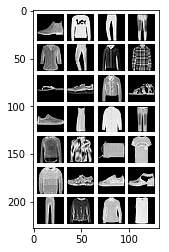

In [3]:
BATCH_SIZE = 512
kwargs = {'num_workers': 0, 'pin_memory': params["use_cuda"]}
data_dir = "/home/jupyter/REPOS/VAE_PYRO"

trainset = torchvision.datasets.FashionMNIST(data_dir, train=True, download=True, transform=tvt.ToTensor())
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, **kwargs)
testset = torchvision.datasets.FashionMNIST(data_dir, train=False, download=True, transform=tvt.ToTensor())
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, **kwargs)

imgs,labels = next(iter(testloader))

print(imgs.shape)
show_batch(imgs[:28],npadding=4)

### Instantiate VAE class 
This is the case without latent structure

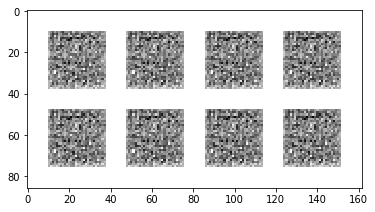

In [4]:
from encoder_decoder import *
from vae import *

#encoder = Encoder_MLP(params)
#decoder = Decoder_MLP(params)
encoder = Encoder_CONV(params)
decoder = Decoder_CONV(params)
vae = VAE(params,encoder,decoder)

vae.guide()
vae.model()
if(params['use_cuda']):
    imgs=imgs.cuda()
imgs_rec = vae.reconstruct(imgs)
show_batch(imgs_rec[:8])

In [5]:
### test_model(vae.model,vae.guide,Trace_ELBO())
### 
### #load_model(vae,"/Users/ldalessi/ENUMERATION_MNIST/ARCHIVE/","vae_v5_10")
### 
### import pyro.poutine as poutine
### #
### print("----MODEL---------")
### trace = poutine.trace(vae.model).get_trace()
### trace.compute_log_prob()  # optional, but allows printing of log_prob shapes
### print(trace.format_shapes())
### #
### print("----GUIDE ---------")
### trace = poutine.trace(vae.guide).get_trace()
### trace.compute_log_prob()  # optional, but allows printing of log_prob shapes
### print(trace.format_shapes())

In [6]:
pyro.clear_param_store()
pyro.set_rng_seed(0)

TEST_FREQUENCY = 5
WRITE_FREQUENCY = 20
smoke_test= False
if(smoke_test):
    pyro.enable_validation(True)
    pyro.distributions.enable_validation(True)
    NUM_EPOCHS = 21
else:
    pyro.enable_validation(False)
    pyro.distributions.enable_validation(False)
    NUM_EPOCHS = 101
    
# setup the optimizer
optimizer = Adamax({"lr": 1.0e-2, "betas":(0.9, 0.999)})
#optimizer = RMSprop({"lr": 1.0e-4})



svi = SVI(vae.model, vae.guide, optimizer, loss=Trace_ELBO(num_particles=1))
train_loss, test_loss = [], []
min_loss = 999999

In [7]:
#write_dir  = '/Users/ldalessi/VAE_PYRO/ARCHIVE/'
write_dir = "/home/jupyter/REPOS/VAE_PYRO/ARCHIVE/"

descriptor      = "Fashion_MNIST_scale_2.0"
name_vae        = "vae_"+descriptor+"_"
name_train_loss = "train_loss_"+descriptor+"_"
name_test_loss  = "test_loss_"+descriptor+"_"
name_params     = "params_"+descriptor


save_obj(params,write_dir,name_params)

In [ ]:
# training loop
for epoch in range(0,NUM_EPOCHS):
    vae.train()            
    
    loss = train(svi,trainloader,use_cuda=params['use_cuda'],verbose=(epoch ==0))
    train_loss.append(loss)   
    print("[epoch %03d] train loss: %.4f" % (epoch, loss))
    
    if(epoch % TEST_FREQUENCY == 0):
        vae.eval()
        loss = evaluate(svi,testloader,use_cuda=params['use_cuda'],verbose=(epoch ==0))
        test_loss.append(loss)
    
        if(test_loss[-1] < min_loss):
            print("[epoch %03d] test  loss: %.4f --New Record--" % (epoch, loss)) 
            min_loss = test_loss[-1]
            #### Save if you got a record 
            ###save_model(vae,write_dir,name_vae+str(epoch))       
            ###save_obj(test_loss,write_dir,name_test_loss+str(epoch))
            ###save_obj(train_loss,write_dir,name_train_loss+str(epoch))
        else:
            print("[epoch %03d] test  loss: %.4f " % (epoch, loss))
            
    if(epoch % WRITE_FREQUENCY == 0):
        save_model(vae,write_dir,name_vae+str(epoch))       
        save_obj(test_loss,write_dir,name_test_loss+str(epoch))
        save_obj(train_loss,write_dir,name_train_loss+str(epoch))

loss=4285462.84741
loss=189788586.14746
loss=528148639.69043
loss=1830552.48169
loss=2193646.07581
loss=2447619.10669
loss=2619794.37439
loss=2790283.29071
loss=2815263.05237
loss=2796563.37384
loss=2818753.20770
loss=2879878.27856
loss=2875765.16064
loss=2842920.65503
loss=2991966.52106
loss=2889596.03577
loss=3016902.86316
loss=2738076.51697
loss=2886122.07251
loss=2932689.49939
loss=2732426.88556
loss=2754998.74890
loss=2881513.09204
loss=2787165.84955
loss=2695954.52954
loss=2615066.01404
loss=2666424.15875
loss=2601355.10938
loss=2710160.47430
loss=2614516.49188
loss=2504348.60107
loss=2473750.41101
loss=2363191.28870
loss=2410835.28180
loss=2274449.25208
loss=2178313.20673
loss=2103436.65564
loss=2131204.67542
loss=2106512.13336
loss=2046141.24390
loss=2036889.75623
loss=1981834.66895
loss=1973668.56567
loss=1874458.16675
loss=1818472.09320
loss=1774411.16638
loss=1760025.35645
loss=1699714.65417
loss=1654453.93506
loss=1628826.15930
loss=1604002.75818
loss=1599564.00073
loss=157

# Check the results

In [ ]:
#write_dir = '/Users/ldalessi/VAE_PYRO/ARCHIVE/'

#descriptor      = "MNIST_v1"

#load_model(vae,write_dir,"vae_"+descriptor+"_400")
#test_loss = load_obj(write_dir,"test_loss_"+descriptor+"_400")
#train_loss = load_obj(write_dir,"train_loss_"+descriptor+"_400")
#name_vae = "vae_"+descriptor

In [ ]:
from matplotlib import pyplot as plt

#plt.yscale('log')
y_shift=0
x_shift=0
plt.plot(np.arange(x_shift, x_shift+len(train_loss)), np.array(train_loss)+y_shift)
plt.plot(np.arange(x_shift, x_shift+len(train_loss), TEST_FREQUENCY), np.array(test_loss)+y_shift, '.--')
plt.xlabel('epoch')
plt.ylabel('LOSS = - ELBO')
plt.title('Training procedure')
plt.ylim(top = 760)
#plt.xlim(xmin = 0, xmax=700)
plt.grid(True)
plt.legend(['train', 'test'])
#plt.show()


plt.savefig(write_dir+name_vae+'train.png')

In [ ]:
#imgs,labels = next(iter(testloader))
imgs,labels = next(iter(trainloader))
if(params['use_cuda']):
    imgs=imgs.cuda()
imgs_rec = vae.reconstruct(imgs)
show_2_batch(imgs[:12],imgs_rec[:12],npadding=4,nrow=6)
plt.savefig(write_dir+name_vae+'rec.png')

# compute the embedding

In [ ]:
z_tot      = np.empty([0,params['DIM_Z']])
labels_tot = np.empty([0])
for data in testloader:
    if z_tot.shape[0] >= 6000:
        break

    imgs,labels = data
    if(params['use_cuda']):
        imgs=imgs.cuda()
    z = vae.encoder(imgs)

    z_tot = np.concatenate((z_tot, z.z_mu.view(-1,params['DIM_Z']).detach().cpu().numpy()),axis=0)
    labels_tot = np.concatenate((labels_tot, labels.numpy()),axis=0)

print("z_tot.shape",z_tot.shape)
print("labels_tot.shape",labels_tot.shape)

# Clear the data

In [ ]:
z_tot[np.isnan(z_tot)] = 0
z_tot[z_tot > 100] = 0
print(z_tot.shape)
print(z_tot[labels_tot==0].shape)
print(labels_tot.shape)

In [ ]:
for k in np.unique(labels_tot):
    plt.plot(z_tot[labels_tot==k, 0], 
             z_tot[labels_tot==k, 1], '.', ms=8, alpha=0.5)

       
lgnd = plt.legend(np.unique(labels_tot).astype(int), 
                  loc='center left', bbox_to_anchor=(1, 0.5))
for i in range(len(lgnd.legendHandles)):
    lgnd.legendHandles[i]._legmarker.set_markersize(20)
    lgnd.legendHandles[i]._legmarker.set_alpha(1)

plt.xlabel('z 0')
plt.ylabel('z 1')
plt.title('Visualization of raw z')
plt.box(on=None)
plt.show()
plt.savefig(write_dir+name_vae+'raw_z.png')

In [ ]:
cluster = dict()
for k in np.unique(labels_tot):
    mean_tmp = np.mean(z_tot[labels_tot == k],axis=0)
    #print(mean_tmp.shape)
    cluster[k] = mean_tmp
    

In [ ]:
print(cluster)

In [ ]:
for key, mean in cluster.items(): # Again, iteritems() for memory-efficiency
    plt.plot(mean[0],mean[1],'.', ms=20, alpha=0.5,label=int(key))
    plt.legend(loc='right')
    plt.box(on=None)

In [ ]:
# and I know this sounds ridiculous but we have to do more
# dimensionality reduction to visualize our dimensionality reduction

from sklearn.manifold import TSNE
z_tsne = TSNE(n_components=2).fit_transform(z_tot)

In [ ]:
plt.rcParams.update({'font.size': 14})

plt.figure(figsize=(8, 8), frameon=False)
for k in np.unique(labels_tot):
    plt.plot(z_tsne[labels_tot==k, 0], 
             z_tsne[labels_tot==k, 1], '.', ms=8, alpha=0.5)

lgnd = plt.legend(np.unique(labels_tot).astype(int), 
                  loc='center left', bbox_to_anchor=(1, 0.5))
for i in range(len(lgnd.legendHandles)):
    lgnd.legendHandles[i]._legmarker.set_markersize(20)
    lgnd.legendHandles[i]._legmarker.set_alpha(1)

plt.xlabel('TSNE 0')
plt.ylabel('TSNE 1')
plt.title('Visualization of embedding')
plt.box(on=None)
plt.show()
plt.savefig(write_dir+name_vae+'embedding.png')